In [3]:
import pandas as pd
import numpy as np
from google.colab import files
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, MultiLabelBinarizer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import (
    RandomForestClassifier,
    RandomForestRegressor,
    AdaBoostClassifier,
    GradientBoostingClassifier,
    VotingClassifier,
    StackingClassifier
)
from sklearn.svm import SVC, SVR
from sklearn.linear_model import (
    LogisticRegression,
    LinearRegression,
    Lasso,
    Ridge
)
from sklearn.multiclass import OneVsRestClassifier
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
df = pd.read_csv("/content/llm_comparison_dataset.csv")

In [5]:
print(df.columns.tolist())

['Model', 'Provider', 'Context Window', 'Speed (tokens/sec)', 'Latency (sec)', 'Benchmark (MMLU)', 'Benchmark (Chatbot Arena)', 'Open-Source', 'Price / Million Tokens', 'Training Dataset Size', 'Compute Power', 'Energy Efficiency', 'Quality Rating', 'Speed Rating', 'Price Rating']


In [6]:
TARGET = 'Model'

In [7]:
is_reg = pd.api.types.is_numeric_dtype(df[TARGET])  # Reference 'Model' as a string
print(f"→ {'Regression' if is_reg else 'Classification'} problem detected.")

→ Classification problem detected.


In [8]:
ALL_FEATURES = [c for c in df.columns if c != TARGET]
SPEED_QUALITY_PRICE = [c for c in ['Speed', 'Quality', 'Price'] if c in df.columns]
feature_groups = {
    'All Features': ALL_FEATURES,
    'Speed+Quality+Price': SPEED_QUALITY_PRICE,
}

In [9]:
X_raw = df.drop(columns=[TARGET])
y_raw = df[TARGET]

In [10]:
if y_raw.dtype == object and y_raw.str.contains(',').any():
    mlb = MultiLabelBinarizer()
    y = mlb.fit_transform(y_raw.str.split(','))
    is_multilabel = True
else:
    y = y_raw
    is_multilabel = False

In [11]:
X = pd.get_dummies(X_raw, drop_first=True)

In [12]:
if not is_reg:
    # Base classifiers
    base_models = {
        'svc': SVC(probability=True),
        'dt': DecisionTreeClassifier(random_state=42),
        'rf': RandomForestClassifier(n_estimators=100, random_state=42),
        'lr': LogisticRegression(max_iter=1000),
    }
    # Ensembles
    models = {
        **{name.upper(): OneVsRestClassifier(clf) if is_multilabel else clf
           for name, clf in base_models.items()},
        'Voting (hard)': VotingClassifier(
            estimators=[(n, clf) for n, clf in base_models.items()], voting='hard'),
        'Voting (soft)': VotingClassifier(
            estimators=[(n, clf) for n, clf in base_models.items()], voting='soft'),
        'AdaBoost': AdaBoostClassifier(
            estimator=DecisionTreeClassifier(max_depth=1), n_estimators=50, random_state=42),
        'GradientBoost': GradientBoostingClassifier(n_estimators=100, random_state=42),
        'Stacking': StackingClassifier(
            estimators=[(n, clf) for n, clf in base_models.items()],
            final_estimator=LogisticRegression(), cv=5),
    }
    scoring = 'accuracy'
else:
    models = {
        'Linear Reg': LinearRegression(),
        'Polynomial Reg': Pipeline([
            ('poly', PolynomialFeatures(degree=2, include_bias=False)),
            ('lr', LinearRegression())
        ]),
        'SVR': SVR(),
        'Lasso': Lasso(alpha=1.0, max_iter=10000),
        'Ridge': Ridge(alpha=1.0),
        'DT Regressor': DecisionTreeRegressor(random_state=42),
        'RF Regressor': RandomForestRegressor(n_estimators=100, random_state=42),
        'AdaBoost Regr': AdaBoostClassifier(),  # Correct AdaBoost regression (no base_estimator)
        'GradientBoost Regr': GradientBoostingClassifier(),
        'Stacking Regr': StackingClassifier(
            estimators=[('lr', LinearRegression()), ('dt', DecisionTreeRegressor(random_state=42))],
            final_estimator=Ridge(), cv=5),
    }
    scoring = 'neg_root_mean_squared_error'

In [13]:
!pip install pandas scikit-learn matplotlib seaborn

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:1380: RuntimeWarning: Number of classes in training fold (62) does not match total number of classes (64). Results may not be appropriate for your use case. To fix this, use a cross-validation technique resulting in properly stratified folds
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:1380: RuntimeWarning: Number of classes in training fold (61) does not match total number of classes (64). Results may not be appropriate for your use case. To fix this, use a cross-validation technique resulting in properly stratified folds
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:1380: RuntimeWarning: Number of classes in training fo

Feature group Speed+Quality+Price has no valid features in the dataset.

=== Accuracy Results ===


,Feature Group,Model,Accuracy (%)
6,All Features,AdaBoost,7.5
8,All Features,Stacking,5.0
0,All Features,SVC,2.5
1,All Features,DT,0.0
2,All Features,RF,0.0
3,All Features,LR,0.0
4,All Features,Voting (hard),0.0
5,All Features,Voting (soft),0.0
7,All Features,GradientBoost,0.0


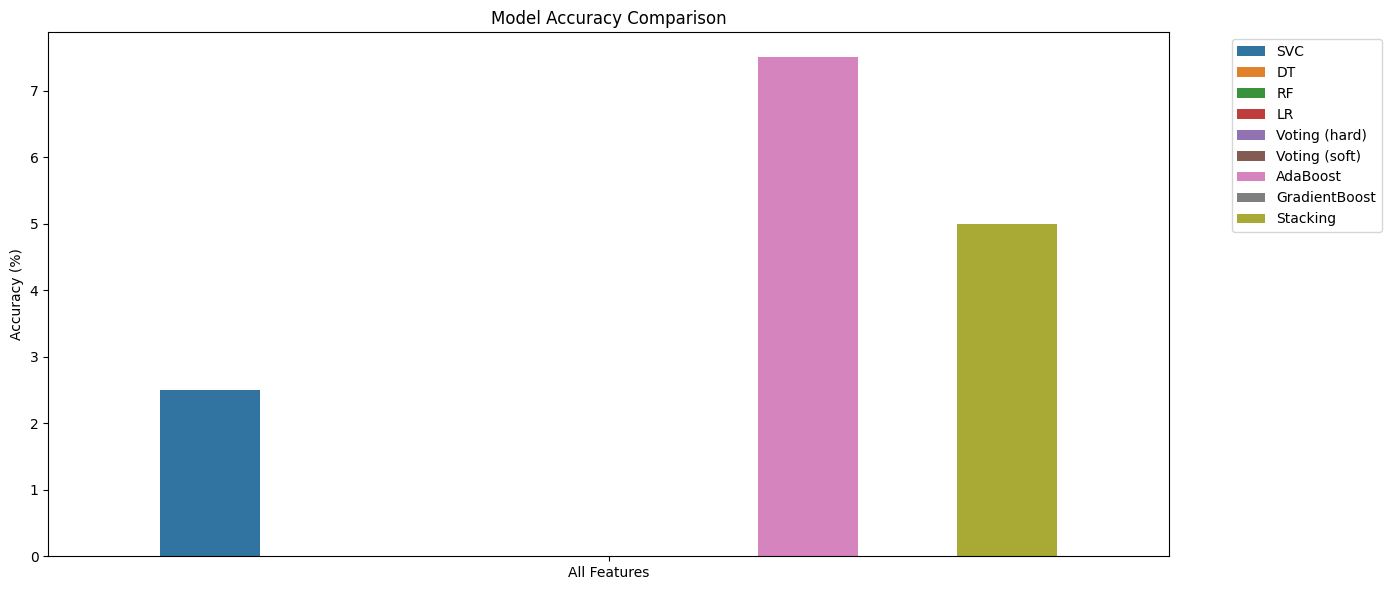

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error
import numpy as np

# 9. Train-test split and accuracy calculation
results = []

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

for fg_name, feats in feature_groups.items():
    feats = [f for f in feats if f in X.columns]

    # Check if the feature group is empty
    if not feats:
        print(f"Feature group {fg_name} has no valid features in the dataset.")
        continue

    X_train_fg = X_train[feats]
    X_test_fg = X_test[feats]

    # Check for missing or invalid values in X_train_fg and X_test_fg
    if X_train_fg.isnull().any().any() or X_test_fg.isnull().any().any():
        print(f"Warning: Missing values found in feature group {fg_name}. Imputing...")
        X_train_fg = X_train_fg.fillna(X_train_fg.mean())
        X_test_fg = X_test_fg.fillna(X_test_fg.mean())

    for name, model in models.items():
        try:
            pipe = Pipeline([
                ('scaler', StandardScaler()),
                ('model', model)
            ])
            pipe.fit(X_train_fg, y_train)
            y_pred = pipe.predict(X_test_fg)

            # If classification, calculate accuracy as percentage
            if not is_reg:
                accuracy = accuracy_score(y_test, y_pred) * 100  # Accuracy as percentage
                results.append({
                    'Feature Group': fg_name,
                    'Model': name,
                    'Accuracy (%)': accuracy
                })
            else:
                # For regression, calculate RMSE as well
                mse = mean_squared_error(y_test, y_pred)
                rmse = np.sqrt(mse)
                results.append({
                    'Feature Group': fg_name,
                    'Model': name,
                    'RMSE': rmse
                })

        except ValueError as e:
            print(f"Error with model {name} for feature group {fg_name}: {e}")

results_df = pd.DataFrame(results)

# 10. Display
print("\n=== Accuracy Results ===")
display(results_df.sort_values(['Feature Group', 'Accuracy (%)'], ascending=[True, False]))

# 11. Plot
plt.figure(figsize=(14, 6))
sns.barplot(data=results_df, x='Feature Group', y='Accuracy (%)', hue='Model')
plt.ylabel('Accuracy (%)' if not is_reg else 'RMSE')
plt.title('Model Accuracy Comparison')
plt.xlabel('')
plt.xticks(rotation=0)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [15]:
best_row = results_df.loc[results_df['Accuracy (%)'].idxmax()]
best_model_name = best_row['Model']
best_feature_group = best_row['Feature Group']
best_accuracy = best_row['Accuracy (%)']

print(f"Best model: {best_model_name}")
print(f"Feature set: {best_feature_group}")
print(f"Test‑set accuracy: {best_accuracy:.2f}%")


Best model: AdaBoost
Feature set: All Features
Test‑set accuracy: 7.50%


In [16]:
df['speed_norm'] = (df['Speed (tokens/sec)'] - df['Speed (tokens/sec)'].min()) / \
                   (df['Speed (tokens/sec)'].max() - df['Speed (tokens/sec)'].min())

df['latency_norm'] = 1 - ((df['Latency (sec)'] - df['Latency (sec)'].min()) / \
                         (df['Latency (sec)'].max() - df['Latency (sec)'].min()))

w_speed, w_latency = 0.6, 0.4

df['composite_score'] = w_speed * df['speed_norm'] + w_latency * df['latency_norm']

best = df.loc[df['composite_score'].idxmax()]

print("Best LLM by Speed/Latency composite:")
print(f"  Model: {best['Model']}")
print(f"  Composite Score: {best['composite_score']:.3f}")
print(f"    Speed:   {best['Speed (tokens/sec)']} (norm={best['speed_norm']:.3f})")
print(f"    Latency: {best['Latency (sec)']} (norm={best['latency_norm']:.3f})")


Best LLM by Speed/Latency composite:
  Model: Gemini-6
  Composite Score: 0.942
    Speed:   292 (norm=0.993)
    Latency: 3.17 (norm=0.866)
